<a href="https://colab.research.google.com/github/lorenzobalzani/bayesian-network-credit-cards/blob/master/bayesian_network_credit_cards_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Networks for probabilistic reasoning over credit cards' default
## Project report for the Fundamentals of AI and KR course - module 3
### Authors: [**Lorenzo Balzani**](mailto:lorenzo.balzani@studio.unibo.it) and [**Thomas Guizzetti**](mailto:thomas.guizzetti@studio.unibo.it)

# Abstract
TODO

# Setup

## Requirements

In [2]:
!pip install -q pandas numpy pgmpy

     |████████████████████████████████| 1.9 MB 4.8 MB/s 


## Imports

In [3]:
from __future__ import annotations # for type annotations
import os, logging
import pandas as pd
import numpy as np
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork, NaiveBayes
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator, BayesianEstimator, ExhaustiveSearch, TreeSearch, HillClimbSearch, MmhcEstimator, BDeuScore, BicScore
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score

# Viz
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

## Declarations

In [4]:
logger = logging.getLogger()
dataset_url = 'https://raw.githubusercontent.com/lorenzobalzani/bayesian-network-credit-cards/master/dataset.csv'
test_ratio = 0.2
random_seed = 42

# Dataset

In [5]:
def read_dataset(url: str) -> pd.DataFrame:
  dataset = pd.read_csv(url, delimiter=';').set_index('ID') \
            .rename(columns={'default payment next month': 'default'})
  return dataset.drop(columns=[column for column in dataset.columns if 'AMT' in column]) \
         .rename(columns={column: column.lower() for column in dataset.columns})

dataset = read_dataset(dataset_url)

## Check for missing values
No drops are needed here because the dataset is complete.

In [6]:
np.sum(pd.isnull(dataset), axis=0) # sum over the columns

limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_1        0
pay_2        0
pay_3        0
pay_4        0
pay_5        0
pay_6        0
default      0
dtype: int64

## Distribution of `limit_bal` 
First, we print out the histogram related to the distribution of `limit_bal`, which is the only continuous variable used.

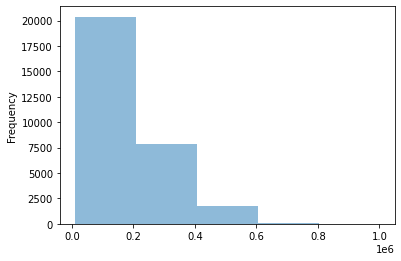

In [7]:
ax = dataset['limit_bal'].plot.hist(bins=5, alpha=0.5)

Next, we describe the distribution. To discretize it, we would like to create four beams (i.e., corresponding to the four percentiles).

In [8]:
dataset['limit_bal'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

## Manipulation
The *artificial column* `misspayments_prev_6_months` can hold either positive, negative numbers or 0. In particular, this means: 
1. $ n = -2 $ corresponds to there was no credit to pay;
2. $ n = -1 $ corresponds to payed successfully;
3. $ n = 0 $ corresponds to a payment that was made on time but not totally to clear the balance (i.e., the minimum payment was met);
4. $ n > 0 $ corresponds to the number of delayed months.

All computations - but `misspayments_prev_6_months` - are performed in a vectorized fashion using NumPy. The less efficient alternative would have used the `apply` method over Pandas DataFrame, which internally leverages a for loop.

In [9]:
%%time

def manipulate_dataset(df: pd.DataFrame) -> pd.DataFrame:
  compute_misspayments = lambda payments_status: sum([payment_status > 0 for payment_status in payments_status])
  df['sex'] = np.where(df['sex'] == 1, 'male', 'female')
  df['marriage'] = np.where(df['marriage'] == 1, 'married', 'not_married')
  df['age'] = np.select([
              (df['age'] < 35), 
              (df['age'] >= 35) & (df['age'] < 60)],
              ['young', 'mid_aged'], default = 'senior')
  df['limit_bal'] = np.select([
                    (df['limit_bal'] < 50_000), 
                    (df['limit_bal'] >= 50_000) & (df['limit_bal'] < 140_000),
                    (df['limit_bal'] >= 140_000) & (df['limit_bal'] < 240_000)],
                    ['low', 'medium', 'medium_high'], default = 'high')
  df['education'] = np.select([
                    (df['education'] == 1), 
                    (df['education'] == 2), 
                    (df['education'] == 3)], 
                    ['graduate', 'university', 'high_school'], default = 'others') 
  df['misspayments_prev_6_months'] = df.apply(lambda row: \
                                              compute_misspayments([row[column] for column in df.columns if 'pay_' in column]), 
                                              axis=1) #axis = 1 means row by row
  return df.drop(columns=[column for column in df.columns if 'pay_' in column])

dataset = manipulate_dataset(read_dataset(dataset_url))

CPU times: user 1.21 s, sys: 19.7 ms, total: 1.23 s
Wall time: 1.36 s


In [10]:
print(f'The dataset contains {dataset.shape[0]} rows, {dataset.shape[1]} columns and it weighs {(dataset.memory_usage(index=True, deep=True).sum() / 10**6):.2f}MB')
dataset.head()

The dataset contains 30000 rows, 7 columns and it weighs 10.37MB


,limit_bal,sex,education,marriage,age,default,misspayments_prev_6_months
ID,,,,,,,
1,low,female,university,married,young,1,2
2,medium,female,university,not_married,young,1,2
3,medium,female,university,not_married,young,0,0
4,medium,female,university,married,mid_aged,0,0
5,medium,male,university,married,mid_aged,0,0


## States
TBC: Description of final dataset and its values
List - for each variable - the associated states, i.e. every possibile unique value in the domain $D$ of a random variable.

In [11]:
{col_name: column.unique() for col_name, column in dataset.iteritems()}

{'limit_bal': array(['low', 'medium', 'high', 'medium_high'], dtype=object),
 'sex': array(['female', 'male'], dtype=object),
 'education': array(['university', 'graduate', 'high_school', 'others'], dtype=object),
 'marriage': array(['married', 'not_married'], dtype=object),
 'age': array(['young', 'mid_aged', 'senior'], dtype=object),
 'default': array([1, 0]),
 'misspayments_prev_6_months': array([2, 0, 1, 4, 5, 6, 3])}

## Train/test splitting

In [12]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('default', axis=1), dataset['default'], \
                                                    test_size=test_ratio, random_state=random_seed, \
                                                    stratify=dataset['default'])
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
print("Training set size: " + str(train.shape[0]))
print("Test set size: " + str(test.shape[0]))
print("Total size: " + str(train.shape[0] + test.shape[0]))

Training set size: 24000
Test set size: 6000
Total size: 30000


# Utility functions

## Plotting networks

In [13]:
def plot_network(network: 'DAG', name: str = 'Network', save_image: bool = False):
  fig, ax = plt.subplots(1, 1, figsize=(12, 12))
  nx.draw_networkx(network, pos=nx.drawing.layout.circular_layout(network), ax=ax, node_size=5000)
  ax.set_title(name)
  if save_image:
    fig.savefig(name)

## Parameter learning (CDPs)
Parameter are estimated given an already-defined $DAG = \{V, E\}$. The estimation is related to every random variable's *CPT*.

In [14]:
def fit_bayesian_network(bayesian_network: BayesianNetwork, prior_type: str = 'BDeu', print_cpd: bool = False) -> Tuple[BayesianNetwork, list]:
  bayesian_network.fit(train, estimator=BayesianEstimator, prior_type = prior_type)
  print('The CPDs contain', 'no' if bayesian_network.check_model() else 'some', 'errors.')
  bn_cpds = bayesian_network.get_cpds()
  if print_cpd:
    TabularCPD._truncate_strtable = lambda self, x: x
    for cpd in bn_cpds:
      print(cpd)
  return bayesian_network, bn_cpds

# Hard-coded networks

## Easy

The CPDs contain no errors.


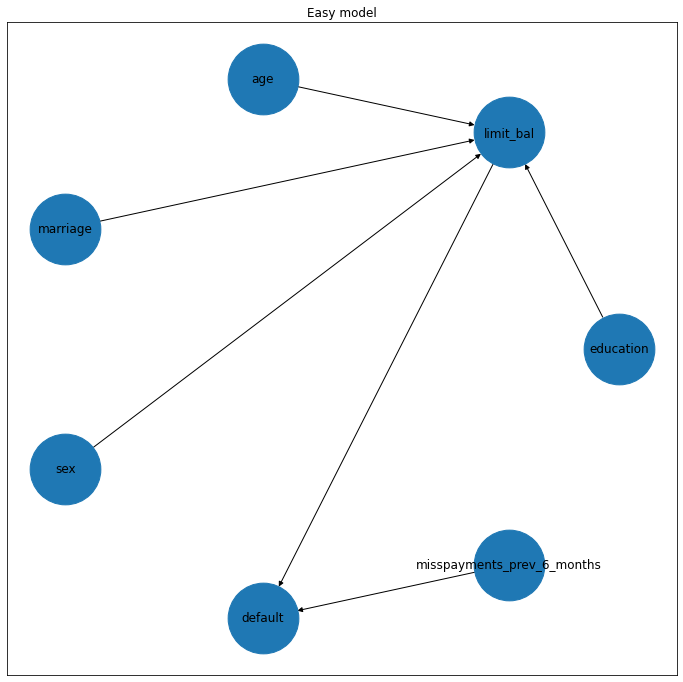

In [15]:
model_easy = BayesianNetwork([('education', 'limit_bal'), ('age', 'limit_bal'), \
                       ('marriage', 'limit_bal'), ('sex', 'limit_bal'), \
                       ('limit_bal', 'default'), ('misspayments_prev_6_months', 'default')])
plot_network(model_easy, 'Easy model')
model_easy, model_easy_cpds = fit_bayesian_network(model_easy, prior_type = 'BDeu', print_cpd = False)

## Medium

The CPDs contain no errors.


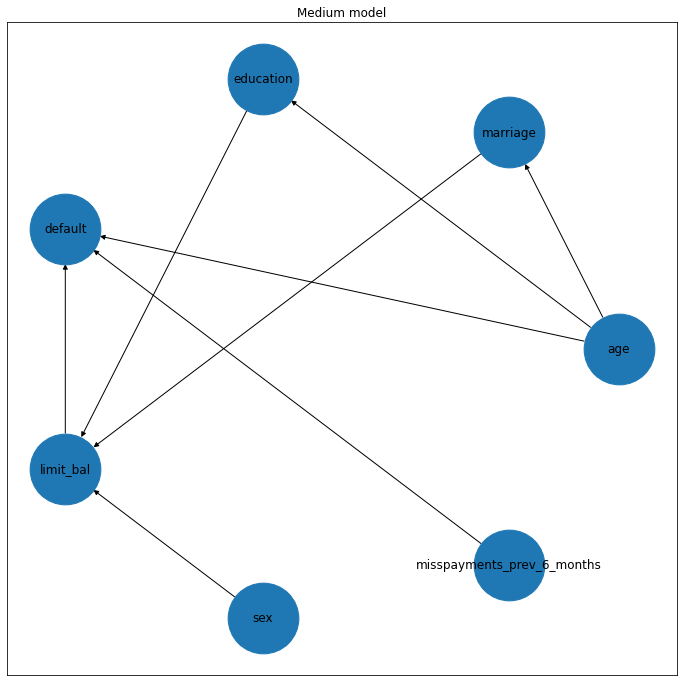

In [16]:
model_medium = BayesianNetwork([("age", "marriage"), ("age", "education"), \
                       ("age", "education"),("age", "default"), \
                       ("education", "limit_bal"), ("marriage", "limit_bal"), \
                       ("limit_bal", "default"), ("sex", "limit_bal"), \
                       ("misspayments_prev_6_months", "default")])
plot_network(model_medium, 'Medium model')
model_medium, model_medium_cpds = fit_bayesian_network(model_medium, prior_type = 'BDeu', print_cpd = False)

## Hard

The CPDs contain no errors.


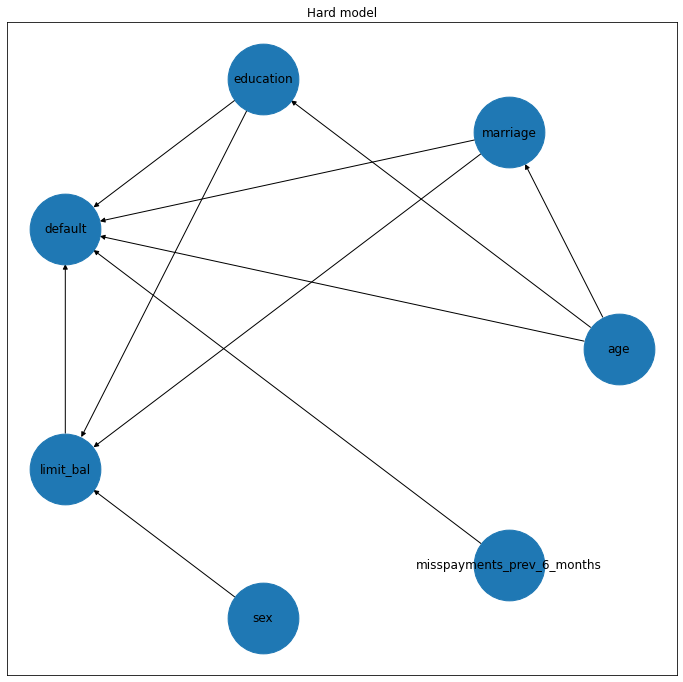

In [17]:
model_hard = BayesianNetwork([("age", "marriage"), ("age", "education"), \
                       ("age", "education"),("age", "default"), \
                       ("education", "limit_bal"), ("marriage", "limit_bal"), \
                       ("limit_bal", "default"), ("sex", "limit_bal"), \
                       ("misspayments_prev_6_months", "default"), ("education", "default"), \
                       ("marriage", "default")])
plot_network(model_hard, 'Hard model')
model_hard, model_hard_cpds = fit_bayesian_network(model_hard, prior_type = 'BDeu', print_cpd = False)

# Structural-learned models
Since query results are poor when comparing the three different models, there is likely no difference betwee the three represetations and thus, we should seek a different model structure.

## Exhaustive Search
Since the ES algorithm cost is super-exponential, it's suited only for small BN, i.e. for networks having less than 5 nodes. In our case, this method is computationally inadequate so will not be included in the networks. 

In [18]:
ex_search = ExhaustiveSearch(data=train, scoring_method=BicScore(data=train))
ex_search_model = ex_search.estimate()
plot_network(ex_search_model, 'Structural Learning - Exhaustive search')
ex_search_model = BayesianNetwork(ex_search_model.edges())
ex_search_model, ex_search_model_cpds = fit_bayesian_network(ex_search_model, prior_type = 'BDeu', print_cpd = False)

KeyboardInterrupt: ignored

## Tree Search

Building tree:   0%|          | 0/21.0 [00:00<?, ?it/s]

The CPDs contain no errors.


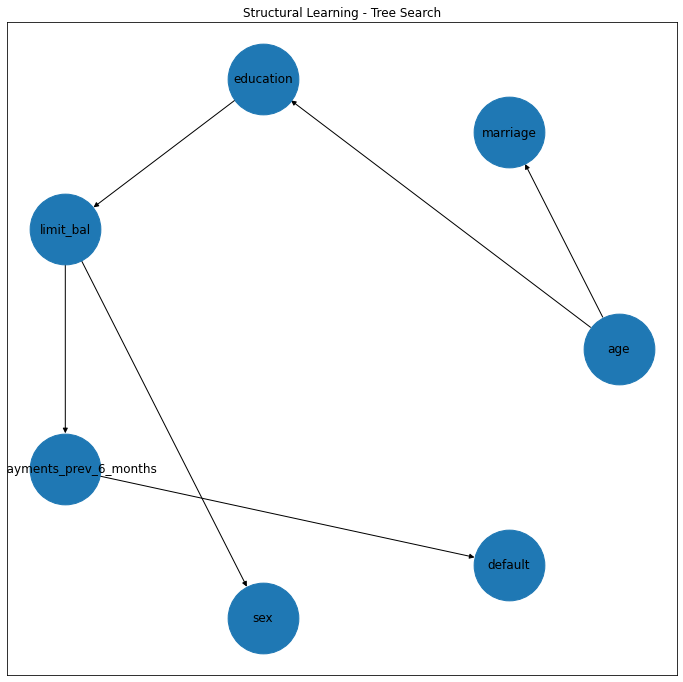

In [19]:
ts = TreeSearch(data=train, root_node='age')
tree_search_model = ts.estimate(show_progress=True)
plot_network(tree_search_model, 'Structural Learning - Tree Search')
tree_search_model = BayesianNetwork(tree_search_model.edges())
tree_search_model, tree_search_cpds = fit_bayesian_network(tree_search_model, prior_type = 'BDeu', print_cpd = False)

## Hill Climb

  0%|          | 0/1000000 [00:00<?, ?it/s]

The CPDs contain no errors.


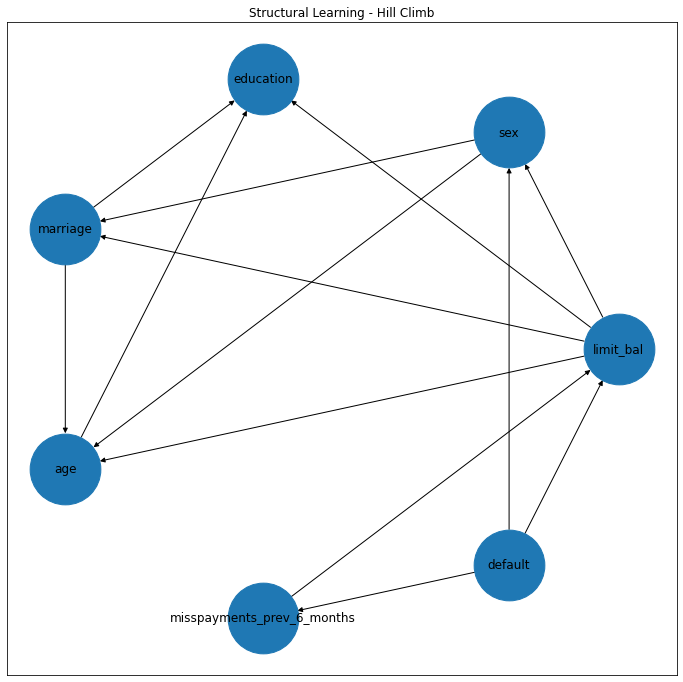

In [20]:
hill_climb = HillClimbSearch(data=train)
hill_climb_base_model = hill_climb.estimate(scoring_method=BDeuScore(data=train), show_progress=True)
plot_network(hill_climb_base_model, 'Structural Learning - Hill Climb')
hill_climb_base_model = BayesianNetwork(hill_climb_base_model.edges())
hill_climb_base_model, hill_climb_base_cpds = fit_bayesian_network(hill_climb_base_model, prior_type = 'BDeu', print_cpd = False)

## Constrained Hill Climb

  0%|          | 0/1000000 [00:00<?, ?it/s]

The CPDs contain no errors.


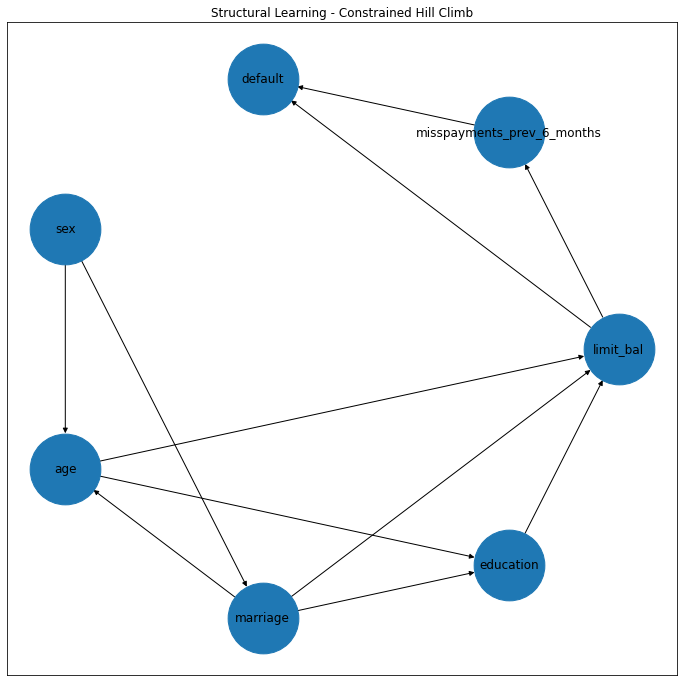

In [21]:
edges_white_list = [('misspayments_prev_6_months', 'default'), ('age','limit_bal')]
edges_black_list = [('limit_bal', 'sex'), ('education', 'sex'), ('age', 'sex')]

hill_climb = HillClimbSearch(data=train)
constr_hill_climb_model = hill_climb.estimate(scoring_method=BDeuScore(data=train), fixed_edges=edges_white_list, \
                                              black_list=edges_black_list, show_progress=True)
constr_hill_climb_model = BayesianNetwork(constr_hill_climb_model.edges())
plot_network(constr_hill_climb_model, 'Structural Learning - Constrained Hill Climb')
constr_hill_climb_model, hill_climb_constr_cpds = fit_bayesian_network(constr_hill_climb_model, prior_type = 'BDeu', print_cpd = False)

# Network analysis

We now have six differently designed Bayesian Networks with CPDs. Let's use the Pgmpy library to explore the local semantics or the networks and their Markov Blankets.

In [56]:
models = [["EASY", model_easy], ["MEDIUM", model_medium], ["HARD", model_hard] \
          ,["TREE SEARCH", tree_search_model], ["HILL CLIMB", hill_climb_base_model], ["CONSTRAINED HILL CLIMB", constr_hill_climb_model]]
nodes = [col_name for col_name, column in dataset.iteritems()]

for model in models:
  print("")
  print('\033[1m' + model[0] + '\033[0m')
  print("")
  print('\033[1m' + "Local semantics: \n" + '\033[0m' + str(model[1].local_independencies(nodes)))
  print('\033[1m' + "Markov Blankets:" + '\033[0m')
  for node in nodes:
    print(f"Markov blanket of node {node}: " + str(model[1].get_markov_blanket(node)))





EASY

Local semantics: 
(limit_bal ⟂ misspayments_prev_6_months | marriage, sex, age, education)
(sex ⟂ marriage, misspayments_prev_6_months, age, education)
(education ⟂ misspayments_prev_6_months, sex, marriage, age)
(marriage ⟂ misspayments_prev_6_months, sex, age, education)
(age ⟂ misspayments_prev_6_months, sex, marriage, education)
(default ⟂ education, marriage, age, sex | limit_bal, misspayments_prev_6_months)
(misspayments_prev_6_months ⟂ sex, age, education, limit_bal, marriage)
Markov Blankets:
Markov blanket of node limit_bal: ['sex', 'age', 'education', 'default', 'misspayments_prev_6_months', 'marriage']
Markov blanket of node sex: ['age', 'education', 'limit_bal', 'marriage']
Markov blanket of node education: ['sex', 'age', 'limit_bal', 'marriage']
Markov blanket of node marriage: ['sex', 'age', 'education', 'limit_bal']
Markov blanket of node age: ['sex', 'education', 'limit_bal', 'marriage']
Markov blanket of node default: ['limit_bal', 'misspayments_prev_6_months']


Let's see how the three characterising types of a Bayesian Network (common parent, cascade and V-structure) impact indipendencies within the networks.

__Common parent__:

In TREE SEARCH,we have that _marriage_ <- _age_ -> _education_. Hence we say that _age_ is a common parent to _marriage_ and _education_. Let's visualise the independencies that it generates:

In [65]:
print(tree_search_model.local_independencies(['age', 'marriage', 'education']))

(marriage ⟂ sex, education, misspayments_prev_6_months, default, limit_bal | age)
(education ⟂ marriage | age)


This shows how education and marriage are indipendent given age, which is indeed a result given by their structure in the network. Moreover, we can see that since _age_ is the only node in the Markov Blanket of _marriage_, the latter is indeed indipendent to the rest of the network given _age_.

__Cascade__:

In TREE SEARCH, we have that _age_ -> _education_ -> _limit-bal_ is a cascade. Let's visualise the independencies that it generates:

In [67]:
print(tree_search_model.local_independencies(['age', 'education', 'limit_bal']))

(education ⟂ marriage | age)
(limit_bal ⟂ marriage, age | education)


This shows that given _education_, _age_ and _limit-bal_ are independent, which is again a given in a cascade structure. 

__V-structure__:

In EASY, we can see that _limit-bal_ -> _default_ <- _misspayment-prev-6-months_. We call this a V-structure. Let's visualise once again the independencies generated: 

In [69]:
print(model_easy.local_independencies(['limit_bal', 'default', 'misspayments_prev_6_months']))

(limit_bal ⟂ misspayments_prev_6_months | marriage, sex, age, education)
(default ⟂ education, marriage, age, sex | limit_bal, misspayments_prev_6_months)
(misspayments_prev_6_months ⟂ sex, age, education, limit_bal, marriage)


We can see already that _limit-bal_ is independent to _misspayment-prev-6-months_ when default is not observed. Let's now formalise this a little by proving the below independence relationship:

* P(_limit-bal_ AND _misspayments-prev-6-months_) = P(_limit-bal_) * P(_misspayments_prev_6_months_)

* P(_limit-bal_ AND _misspayments-prev-6-months_ | _default_) != P(_limit-bal_ | _default_) * P(_misspayments-prev-6-months_ | _default_)


In [97]:

print("P(limit-bal AND misspayments-prev-6-months) = P(limit-bal) * P(misspayments_prev_6_months) is " + \
      str(VariableElimination(model_easy).query(["misspayments_prev_6_months", "limit_bal"]) == \
      VariableElimination(model_easy).query(["limit_bal"]) * VariableElimination(model_easy).query(["misspayments_prev_6_months"])))

print("P(limit-bal AND misspayments-prev-6-months | default) = P(limit-bal | default) * P(misspayments_prev_6_months | default) is " + \
      str(VariableElimination(model_easy).query(["misspayments_prev_6_months", "limit_bal"], {"default":0}) == \
      VariableElimination(model_easy).query(["limit_bal"], {"default":0}) * VariableElimination(model_easy).query(["misspayments_prev_6_months"], {"default":0})))

P(limit-bal AND misspayments-prev-6-months) = P(limit-bal) * P(misspayments_prev_6_months) is True
P(limit-bal AND misspayments-prev-6-months | default) = P(limit-bal | default) * P(misspayments_prev_6_months | default) is False


Indeed we have that limit_bal is independent to misspayments_prev_6_months when default is not observed, while limit_bal is conditionally dependent to misspayments_prev_6_months when default is observed.

# Queries
* P(Default | age) 
* P(Default | age, marriage)
* P(Default | age, marriage, education)
* P(Education = graduate | default)
* P(Default | Education = graduate, Misspayment = 5)
* P(Default | Education = High school, Misspayment = 5)

*TBC: Explain why we're using variable elimination (Optional, construct algorigthm instead of using class)*

In [ ]:
data_infer_easy = VariableElimination(model_easy)
data_infer_medium = VariableElimination(model_medium)
data_infer_hard = VariableElimination(model_hard)
data_infer_tree_search = VariableElimination(tree_search_model)
data_infer_hill_climb = VariableElimination(hill_climb_base_model)
data_infer_constr_hill_climb = VariableElimination(constr_hill_climb_model)

def display_inference_results(query_desc: str, query: list, evidence: dict):
  print(query_desc)
  print('EASY')
  print(data_infer_easy.query(query, evidence))
  print('MEDIUM')
  print(data_infer_medium.query(query, evidence))
  print('HARD')
  print(data_infer_hard.query(query, evidence))
  print('TREE SEARCH')
  print(data_infer_tree_search.query(query, evidence))
  print('HILL CLIMB')
  print(data_infer_hill_climb.query(query, evidence))
  print('CONSTRAINED HILL CLIMB')
  print(data_infer_constr_hill_climb.query(query, evidence))

In [ ]:
query, evidence = ["default"], {"age": "young"}
display_inference_results('Probability of default being young', query, evidence)

Probability of default being young
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7757 |
+------------+----------------+
| default(1) |         0.2243 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7898 |
+------------+----------------+
| default(1) |         0.2102 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7894 |
+------------+----------------+
| default(1) |         0.2106 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7804 |
+------------+----------------+
| default(1) |         0.2196 |
+------------+----------------+
HILL CLIMB
+------------+---------------

In [ ]:
query, evidence = ["default"], {"age": "mid_aged"}
display_inference_results('Probability of default being mid aged', query, evidence)

Probability of default being mid aged
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7818 |
+------------+----------------+
| default(1) |         0.2182 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7650 |
+------------+----------------+
| default(1) |         0.2350 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7665 |
+------------+----------------+
| default(1) |         0.2335 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7770 |
+------------+----------------+
| default(1) |         0.2230 |
+------------+----------------+
HILL CLIMB
+------------+------------

In [ ]:
query, evidence = ["default"], {"age": "senior"}
display_inference_results('Probability of default being mid senior', query, evidence)

Probability of default being mid senior
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7810 |
+------------+----------------+
| default(1) |         0.2190 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7512 |
+------------+----------------+
| default(1) |         0.2488 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7370 |
+------------+----------------+
| default(1) |         0.2630 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7750 |
+------------+----------------+
| default(1) |         0.2250 |
+------------+----------------+
HILL CLIMB
+------------+----------

In [ ]:
query, evidence = ["default"], {"age": "mid_aged", "marriage": "not_married"}
display_inference_results('Probability of default being mid aged and married', query, evidence)

Probability of default being mid aged and married
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7796 |
+------------+----------------+
| default(1) |         0.2204 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7579 |
+------------+----------------+
| default(1) |         0.2421 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7680 |
+------------+----------------+
| default(1) |         0.2320 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7770 |
+------------+----------------+
| default(1) |         0.2230 |
+------------+----------------+
HILL CLIMB
+------------+

In [ ]:
query, evidence = ["default"], {"age": "mid_aged", "marriage": "married", "education": "graduate"}
display_inference_results('Probability of default being mid aged and married and holding a graduate degree', query, evidence)

Probability of default being mid aged and married and holding a graduate degree
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7970 |
+------------+----------------+
| default(1) |         0.2030 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7847 |
+------------+----------------+
| default(1) |         0.2153 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7794 |
+------------+----------------+
| default(1) |         0.2206 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7948 |
+------------+----------------+
| default(1) |         0.2052 |
+------------+-------------

In [ ]:
query, evidence = ["education"], {"default": 1}
display_inference_results('Probabilities of holding education titles having had the default', query, evidence)

Probabilities of holding education titles having had the default
EASY
+------------------------+------------------+
| education              |   phi(education) |
+========================+==================+
| education(graduate)    |           0.3334 |
+------------------------+------------------+
| education(high_school) |           0.1712 |
+------------------------+------------------+
| education(others)      |           0.0158 |
+------------------------+------------------+
| education(university)  |           0.4796 |
+------------------------+------------------+
MEDIUM
+------------------------+------------------+
| education              |   phi(education) |
+========================+==================+
| education(graduate)    |           0.3308 |
+------------------------+------------------+
| education(high_school) |           0.1745 |
+------------------------+------------------+
| education(others)      |           0.0158 |
+------------------------+------------------+
| e

In [ ]:
query, evidence = ["default"], {"education": "graduate", "misspayments_prev_6_months": 5}
display_inference_results('Probability of default holding a graduate degree and having 5 misspayments in the previous 6 months', query, evidence)

Probability of default holding a graduate degree and having 5 misspayments in the previous 6 months
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4177 |
+------------+----------------+
| default(1) |         0.5823 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4228 |
+------------+----------------+
| default(1) |         0.5772 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.5804 |
+------------+----------------+
| default(1) |         0.4196 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4011 |
+------------+----------------+
| default(1) |         0.5989 |
+------

In [ ]:
query, evidence = ["default"], {"education": "high_school", "misspayments_prev_6_months": 5}
display_inference_results('Probability of default holding an high school diploma, and having 5 misspayments in the previous 6 months', query, evidence)

Probability of default holding an high school diploma, and having 5 misspayments in the previous 6 months
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4002 |
+------------+----------------+
| default(1) |         0.5998 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4093 |
+------------+----------------+
| default(1) |         0.5907 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3997 |
+------------+----------------+
| default(1) |         0.6003 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4011 |
+------------+----------------+
| default(1) |         0.5989 |
+

In [ ]:
query, evidence = ["default"], {"limit_bal": "medium_high", "misspayments_prev_6_months": 5}
display_inference_results('Probability of default having a medium-high balance limit, and having 5 misspayments in the previous 6 months', query, evidence)

Probability of default having a medium-high balance limit, and having 5 misspayments in the previous 6 months
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3690 |
+------------+----------------+
| default(1) |         0.6310 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3812 |
+------------+----------------+
| default(1) |         0.6188 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4165 |
+------------+----------------+
| default(1) |         0.5835 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4011 |
+------------+----------------+
| default(1) |         0.5989

In [ ]:
query, evidence = ["default"], {"sex": "male"}
display_inference_results('Probability of default given sex', query, evidence)

Probability of default given sex
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7754 |
+------------+----------------+
| default(1) |         0.2246 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7752 |
+------------+----------------+
| default(1) |         0.2248 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7754 |
+------------+----------------+
| default(1) |         0.2246 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7751 |
+------------+----------------+
| default(1) |         0.2249 |
+------------+----------------+
HILL CLIMB
+------------+----------------+

In [ ]:
query, evidence = ["default"], {"education": "high_school", "misspayments_prev_6_months": 6, 'age': 'young', 'sex': 'female', \
                                'marriage': 'not_married', 'limit_bal': 'low'}
display_inference_results('Probability of default given everything else', query, evidence)

Probability of default given everything else
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3154 |
+------------+----------------+
| default(1) |         0.6846 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3719 |
+------------+----------------+
| default(1) |         0.6281 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3182 |
+------------+----------------+
| default(1) |         0.6818 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3030 |
+------------+----------------+
| default(1) |         0.6970 |
+------------+----------------+
HILL CLIMB
+------------+-----

# Questions

Let's now perform the same queries across the different networks and comment the results.

In [ ]:
query, evidence = ["default"], {"education": "high_school", "misspayments_prev_6_months": 6, 'age': 'young', 'sex': 'female', \
                                'marriage': 'not_married', 'limit_bal': 'low'}
display_inference_results('Probability of default given everything else', query, evidence)

# Quantitative model evalution
So far, the models have been evaluated only in a qualitative manner. In particular a domain-expert can ragionevolemnte tell if the results are good enough. 
The next step is to evaluate the model quantitatively. Since the dataset was created for the classification task, we have leveraged the test set to obtain accuracy, F1/F2, precision, and recall metrics.

In [ ]:
def predict(data_point: dict, inference_object: VariableElimination, query: str) -> Tuple[float, float]:
  result = inference_object.query(variables=['default'], evidence=dict(data_point))
  values = result.state_names[query]
  default = np.argmax(result.values)
  return default, result.values

def predict_batch(batch: pd.DataFrame, inference_object: VariableElimination, query: str) -> list[int]:
  return [predict(data_point[1], inference_object, query)[0] for data_point in batch.iterrows()]

In [ ]:
preds = predict_batch(X_test, data_infer_easy, query = 'default')
print('EASY')
print(f'Accuracy {accuracy_score(y_test, preds):.2%}')
print(f'Recall: {recall_score(y_test, preds):.2%}')
print(f'F1-Score {f1_score(y_test, preds):.2%}')

preds = predict_batch(X_test, data_infer_medium, query = 'default')
print('MEDIUM')
print(f'Accuracy: {accuracy_score(y_test, preds):.2%}')
print(f'Recall: {recall_score(y_test, preds):.2%}')
print(f'F1-Score {f1_score(y_test, preds):.2%}')

preds = predict_batch(X_test, data_infer_hard, query = 'default')
print('HARD')
print(f'Accuracy: {accuracy_score(y_test, preds):.2%}')
print(f'Recall: {recall_score(y_test, preds):.2%}')
print(f'F1-Score {f1_score(y_test, preds):.2%}')

preds = predict_batch(X_test, data_infer_tree_search, query = 'default')
print('TREE SEARCH')
print(f'Accuracy: {accuracy_score(y_test, preds):.2%}')
print(f'Recall: {recall_score(y_test, preds):.2%}')
print(f'F1-Score {f1_score(y_test, preds):.2%}')

preds = predict_batch(X_test, data_infer_hill_climb, query = 'default')
print('HILL CLIMB')
print(f'Accuracy: {accuracy_score(y_test, preds):.2%}')
print(f'Recall: {recall_score(y_test, preds):.2%}')
print(f'F1-Score {f1_score(y_test, preds):.2%}')

preds = predict_batch(X_test, data_infer_constr_hill_climb, query = 'default')
print('CONSTRAINED HILL CLIMB')
print(f'Accuracy: {accuracy_score(y_test, preds):.2%}')
print(f'Recall: {recall_score(y_test, preds):.2%}')
print(f'F1-Score {f1_score(y_test, preds):.2%}')

EASY
Accuracy 80.23%
Recall: 28.26%
F1-Score 38.74%
MEDIUM
Accuracy: 80.20%
Recall: 29.84%
F1-Score 40.00%
HARD
Accuracy: 79.82%
Recall: 27.05%
F1-Score 37.22%
TREE SEARCH
Accuracy: 80.45%
Recall: 33.84%
F1-Score 43.36%
HILL CLIMB
Accuracy: 80.52%
Recall: 30.14%
F1-Score 40.63%
CONSTRAINED HILL CLIMB
Accuracy: 80.20%
Recall: 29.24%
F1-Score 39.51%
